In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import XYZ_to_Lab, delta_E, XYZ_to_RGB, RGB_to_XYZ
from colour.models.rgb import RGB_COLOURSPACES, RGB_to_XYZ
import tifffile
import zarr
from colour_lib.utils import *

# Download features

In [3]:
global_dir = "/uftp/src/"
rw = RawDataParser(reference_basepath=f"{global_dir}calibration_data/")

In [4]:
def coords_read(sz):
    return pd.read_csv(f"{global_dir}saved_coords/manual/huron0224/{sz}um_coords.csv")

In [5]:
images = {
    "R1_111": image_read(
        f"{global_dir}palettes/Calib_R1_10_10_10_202402.tif", 3, "Gamma 1.0"
    ),
    "Polaris": image_read(
        f"{global_dir}palettes/Calib_Polaris_Scan3.qptiff", 6, "Gamma 1.8"
    ),
}
images["R1_111_XYZ"] = RGB_to_XYZ(
    RGB=images["R1_111"], colourspace=RGB_COLOURSPACES["sRGB"]
)

images["Polaris_XYZ"] = RGB_to_XYZ(
    RGB=images["R1_111"], colourspace=RGB_COLOURSPACES["NTSC (1987)"]
)
rads = {
    "4150": 40,
    "1000": 10,
    "750": 6,
    "500": 4,
    "400": 4,
    "300": 2,
    "250": 2,
    "200": 1,
    "150": 1,
    "CA1000": 50,
}
coords = {
    "4150": coords_read(4150),
    "1000": coords_read(1000),
    "750": coords_read(750),
    "500": coords_read(500),
    "400": coords_read(400),
    "300": coords_read(300),
    "250": coords_read(250),
    "200": coords_read(200),
    "150": coords_read(150),
    "CA1000": coords_read("CA1000"),
}

<tifffile.TiffPage 6 @11318147692> missing data offset tag


In [6]:
list(coords.items())[0][1].shape[0]

24

In [7]:
def draw_circle_mask(image, coord, radius):
    mask_shape = image.shape
    coords_y, coords_x = np.ogrid[: mask_shape[0], : mask_shape[1]]
    circle_mask = np.zeros(mask_shape[:2], dtype=bool)
    for idx, centroids in coord.iterrows():
        centroid_y, centroid_x = centroids["Y"], centroids["X"]
        circle_mask = circle_mask | (
            (coords_y - centroid_y) ** 2 + (coords_x - centroid_x) ** 2 <= radius**2
        )

    plt.imshow(image)
    plt.imshow(circle_mask, alpha=0.5)

In [8]:
CA = calc_rectangle(images["R1_111"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangles(
    images["R1_111"],
    coords,
    rads,
    zones=["1000", "750", "500", "400", "300", "250", "200", "150"],
)

/home/gboykov/colour_project/src/colour_lib/utils/circlelib.py:39: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
slide_vals = calc_slide(CA, slide)
slide_vals[1]

array([ 0.        ,  0.15751158,  0.3848427 ])

In [10]:
from colour.models.rgb import RGB_COLOURSPACES, RGB_to_XYZ

SRGB_COLSPACE = RGB_COLOURSPACES["sRGB"]
SRGB_COLSPACE.cctf_encoding(slide_vals[1]) * 255

array([   0.        ,  110.52378999,  166.68991411])

In [11]:
RGB_to_XYZ(
    RGB=slide_vals,
    colourspace=SRGB_COLSPACE,
    illuminant=None,
    chromatic_adaptation_transform=None,
    apply_cctf_decoding=False,
)

array([[ 0.92091705,  0.97160646,  1.05229827],
       [ 0.12579025,  0.14043793,  0.38456837],
       [ 0.18410932,  0.15329275,  0.01988484],
       [ 0.22804235,  0.13679702,  0.14850182],
       [ 0.10631628,  0.17597541,  0.14549881],
       [ 0.57435428,  0.64696061,  0.09460418],
       [ 0.04065583,  0.02456704,  0.15517823],
       [ 0.05230174,  0.04173314,  0.06901198],
       [ 0.85799851,  0.90154229,  0.96430745],
       [ 0.60766369,  0.64222794,  0.70026822],
       [ 0.37339859,  0.39433953,  0.4450934 ],
       [ 0.22063718,  0.16601279,  0.02648141],
       [ 0.3586241 ,  0.33393191,  0.04555377],
       [ 0.46400885,  0.4917151 ,  0.07045462],
       [ 0.29988004,  0.40704639,  0.0798035 ],
       [ 0.17166513,  0.1787331 ,  0.20458631],
       [ 0.05651195,  0.05981363,  0.06118079],
       [ 0.01318717,  0.01268617,  0.0128499 ],
       [ 0.08020761,  0.06555349,  0.29436904],
       [ 0.26007261,  0.36390842,  0.56834886],
       [ 0.25234455,  0.23531387,  0.432

In [12]:
colour_arrays = {
    "exp_srgbs": slide_vals,
    "exp_xyz": RGB_to_XYZ(RGB=slide_vals, colourspace=SRGB_COLSPACE),  # correctted
    "ref_srgbs": rw.get_reference_srgbs(),
    "ref_xyz": rw.get_reference_d65(),
}

# Process

In [13]:
from colour_lib.regressors import *

In [14]:
reg = {
    "PLS_RGB": PLSRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"]),
    "Lasso_RGB": LassoRegressor(
        colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"], 0.01
    ),
    "Vote_RGB": VoteRegressor(
        colour_arrays["exp_srgbs"],
        colour_arrays["ref_srgbs"],
        max_depth=2,
        random_state=0,
        alpha=0.02,
    ),
    "TPS_RGB": TPSRegressor(
        colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"], alpha=0.5
    ),
    "PLS_XYZ": PLSRegressor(colour_arrays["exp_xyz"], colour_arrays["ref_xyz"]),
    "Lasso_XYZ": LassoRegressor(
        colour_arrays["exp_xyz"], colour_arrays["ref_xyz"], 0.01
    ),
    "Vote_XYZ": VoteRegressor(
        colour_arrays["exp_xyz"],
        colour_arrays["ref_xyz"],
        max_depth=2,
        random_state=0,
        alpha=0.02,
    ),
    "TPS_XYZ": TPSRegressor(
        colour_arrays["exp_xyz"], colour_arrays["ref_xyz"], alpha=0.5
    ),
}

In [72]:
import re

reg_names = []
CA = {}
slide = {}
De = {}

for i, v in enumerate(reg):
    reg_names.append(v)
    if re.search(r"RGB", v) != None:
        images[v] = reg[v].predict(images["R1_111"])
    else:
        images[v] = reg[v].predict(images["R1_111_XYZ"])
    CA = calc_rectangle(images[v], coords["CA1000"], rads["CA1000"])
    slide = calc_rectangle(images[v], coords["1000"], rads["1000"])
    colour_arrays[v] = calc_slide(CA, slide)
    if re.search(r"RGB", v) != None:
        De[v] = calculate_delta_E(
            RGB_to_XYZ(RGB=colour_arrays[v], colourspace=SRGB_COLSPACE),
            colour_arrays["ref_xyz"],
        )
    else:
        De[v] = calculate_delta_E(colour_arrays[v], colour_arrays["ref_xyz"])

/home/gboykov/colour_project/src/colour_lib/utils/circlelib.py:39: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gboykov/colour_project/src/colour_lib/utils/circlelib.py:39: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [73]:
reg_names

['PLS_RGB',
 'Lasso_RGB',
 'Vote_RGB',
 'TPS_RGB',
 'PLS_XYZ',
 'Lasso_XYZ',
 'Vote_XYZ',
 'TPS_XYZ']

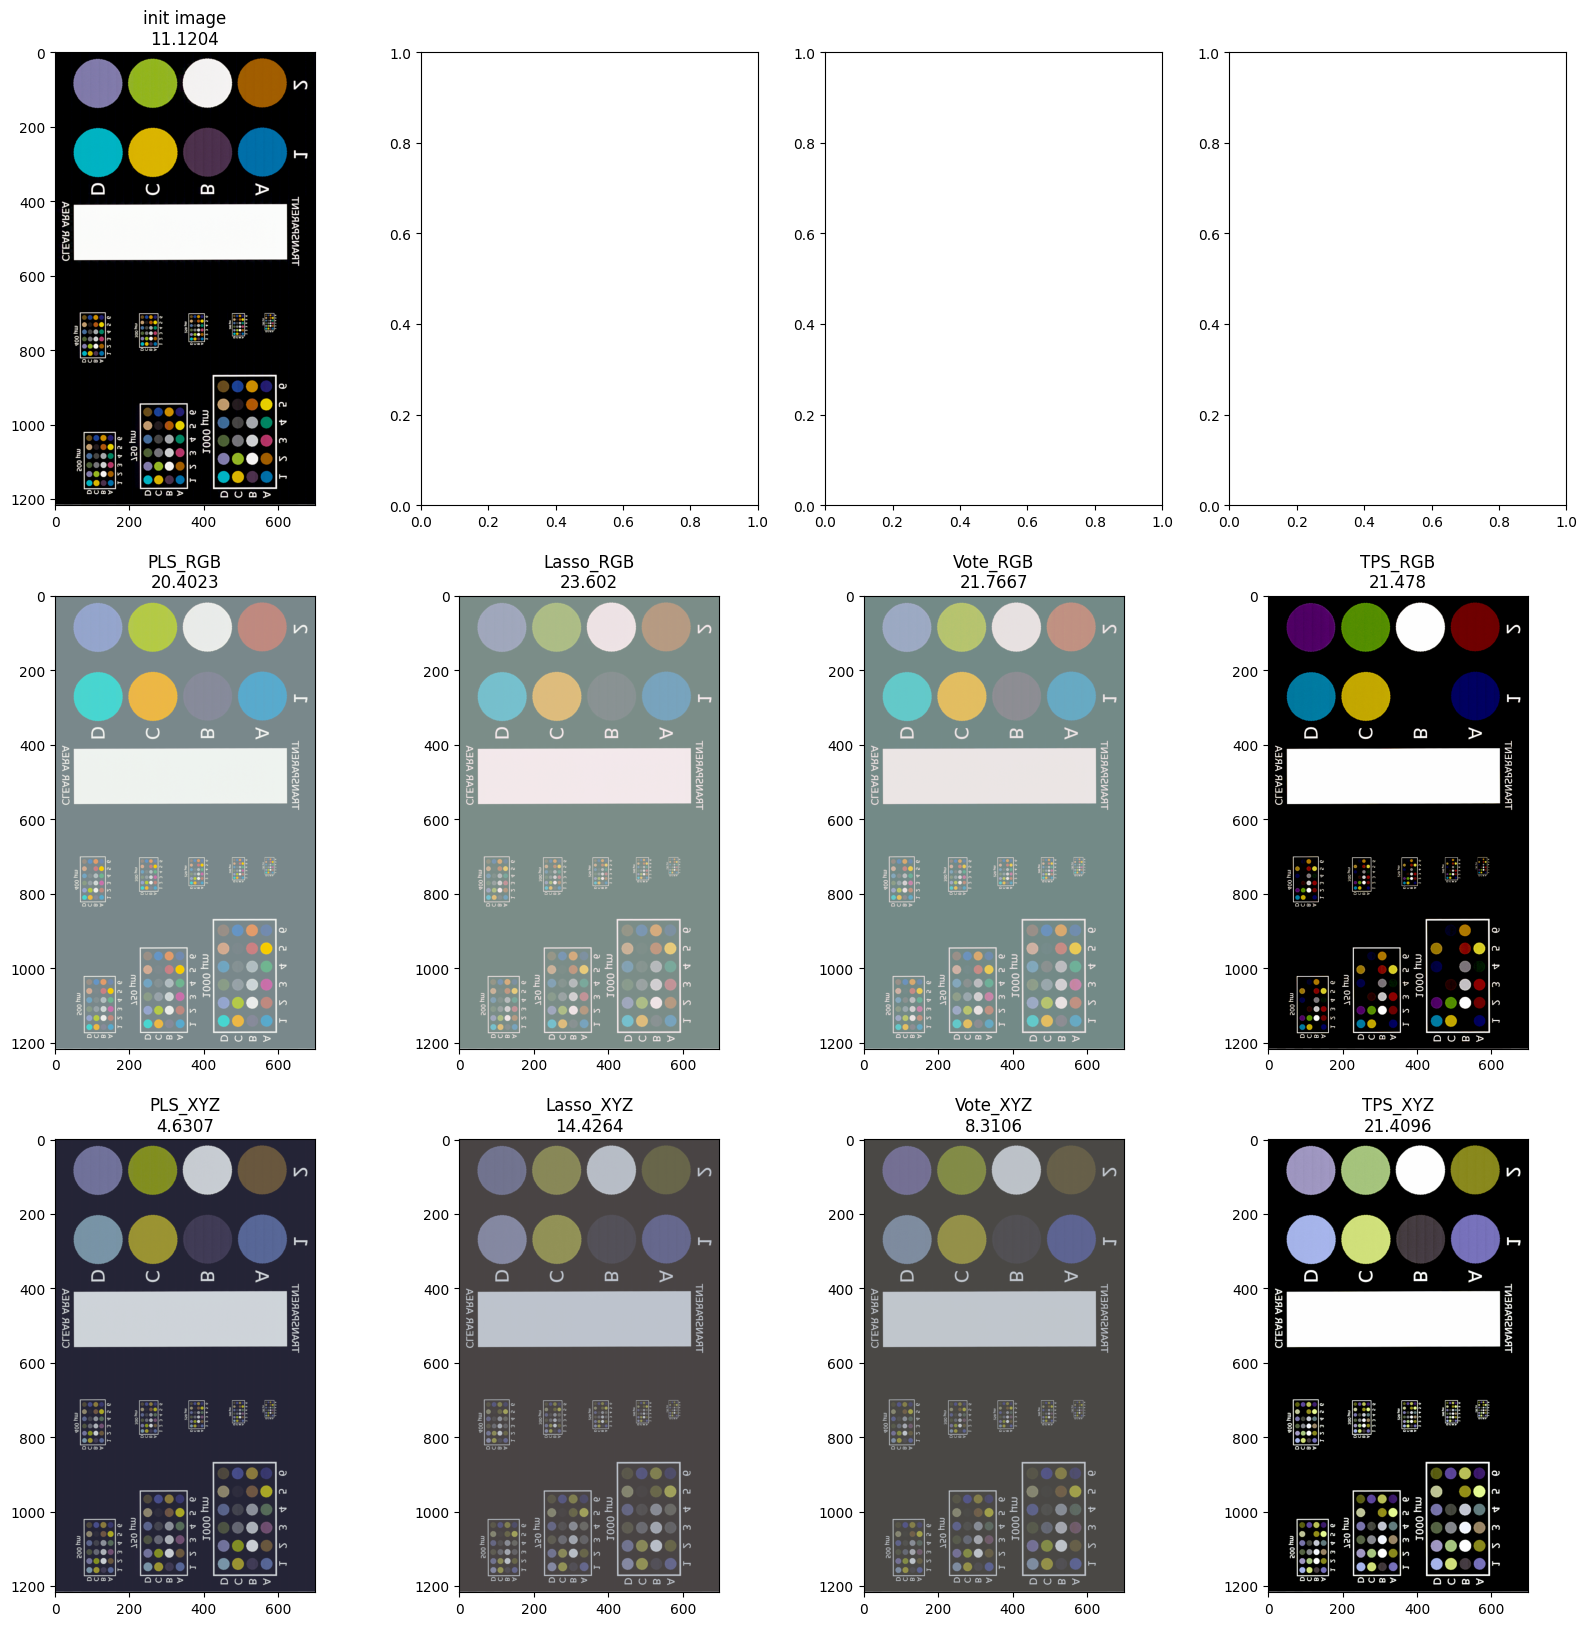

In [77]:
plt.rcParams["figure.figsize"] = (20, 20)
f, axarr = plt.subplots(3, 4)
axarr[0][0].imshow(SRGB_COLSPACE.cctf_encoding(images["R1_111"]))
axarr[0][0].set_title(
    f'init image\n{round(np.mean(calculate_delta_E(RGB_to_XYZ(RGB=colour_arrays["exp_srgbs"], colourspace=SRGB_COLSPACE),colour_arrays["ref_xyz"])), 4)}'
)
k = 0
for i in [1, 2]:
    for j in [0, 1, 2, 3]:
        axarr[i][j].imshow(SRGB_COLSPACE.cctf_encoding(images[reg_names[k]]))
        axarr[i][j].set_title(f"{reg_names[k]}\n{round(np.mean(De[reg_names[k]]), 4)}")
        k = k + 1
# plt.rcParams["figure.figsize"] = (20,3)
# for i, vector in enumerate(name_list):
#     axarr[i].imshow(SRGB_COLSPACE.cctf_encoding(images[vector[0]]))
#     axarr[i].set_title(vector[1])

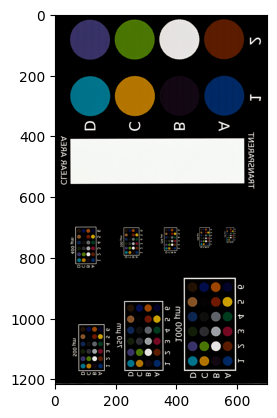

In [ ]:
plt.imshow(images["R1_111"])

In [ ]:
np.mean(
    calculate_delta_E(
        RGB_to_XYZ(RGB=colour_arrays["exp_srgbs"], colourspace=SRGB_COLSPACE),
        colour_arrays["ref_xyz"],
    )
)

11.120379182757549

In [ ]:
np.mean(
    calculate_delta_E(
        RGB_to_XYZ(RGB=colour_arrays["PLS_reg_srgbs"], colourspace=SRGB_COLSPACE),
        colour_arrays["ref_xyz"],
    )
)

20.402339553240598

In [ ]:
np.mean(
    calculate_delta_E(
        RGB_to_XYZ(RGB=colour_arrays["Lasso_reg_srgbs"], colourspace=SRGB_COLSPACE),
        colour_arrays["ref_xyz"],
    )
)

23.601964032159653

In [ ]:
np.mean(
    calculate_delta_E(
        RGB_to_XYZ(RGB=colour_arrays["Test_reg_srgbs"], colourspace=SRGB_COLSPACE),
        colour_arrays["ref_xyz"],
    )
)

20.270348853986633

In [ ]:
calculate_delta_E(
    RGB_to_XYZ(RGB=colour_arrays["exp_srgbs"], colourspace=SRGB_COLSPACE),
    colour_arrays["ref_xyz"],
)

array([[  8.643969  ],
       [ 11.3274873 ],
       [ 28.59727777],
       [  8.19734142],
       [  7.98124241],
       [ 17.33729015],
       [ 11.14989666],
       [  5.90273458],
       [  8.92846133],
       [  9.46986223],
       [  8.84749177],
       [ 26.26738667],
       [ 19.01126427],
       [ 16.69441927],
       [  8.28950651],
       [  8.11425392],
       [  5.44350165],
       [ 10.20741705],
       [  3.64142144],
       [  8.83374515],
       [  9.5272674 ],
       [  1.86182183],
       [  6.62957174],
       [ 14.09266798],
       [ 13.01218007]])

In [ ]:
calculate_delta_E(
    RGB_to_XYZ(RGB=colour_arrays["PLS_reg_srgbs"], colourspace=SRGB_COLSPACE),
    colour_arrays["ref_xyz"],
)

array([[  6.28782341],
       [ 26.28323552],
       [ 32.81769358],
       [ 19.08509903],
       [ 21.30139232],
       [ 13.10816688],
       [ 30.56425386],
       [ 31.2042196 ],
       [  7.07812307],
       [  9.52167512],
       [ 12.79925857],
       [ 24.43743614],
       [ 18.58216014],
       [ 14.0533136 ],
       [ 12.47062454],
       [ 20.20691345],
       [ 27.80027217],
       [ 34.02258875],
       [ 27.15199208],
       [ 13.67000032],
       [ 17.82715546],
       [ 25.70780702],
       [ 21.67536935],
       [ 13.88247652],
       [ 28.51943832]])

In [ ]:
calculate_delta_E(
    RGB_to_XYZ(RGB=colour_arrays["Lasso_reg_srgbs"], colourspace=SRGB_COLSPACE),
    colour_arrays["ref_xyz"],
)

array([[  9.83187104],
       [ 27.07524041],
       [ 40.77933499],
       [ 29.94980639],
       [ 23.1195567 ],
       [ 17.43883899],
       [ 34.03626908],
       [ 36.48459426],
       [  9.91648949],
       [ 10.85621934],
       [ 12.84205865],
       [ 34.06002539],
       [ 23.53703373],
       [ 18.15708578],
       [ 15.27007484],
       [ 20.48244866],
       [ 29.33785624],
       [ 35.99581136],
       [ 28.99528033],
       [ 14.23061402],
       [ 19.40275297],
       [ 26.38084928],
       [ 21.88719455],
       [ 16.82357743],
       [ 33.15821687]])

In [ ]:
calculate_delta_E(
    RGB_to_XYZ(RGB=colour_arrays["Test_reg_srgbs"], colourspace=SRGB_COLSPACE),
    colour_arrays["ref_xyz"],
)

array([[  4.52052303],
       [ 26.95112441],
       [ 29.73221627],
       [ 21.76344978],
       [ 21.81923101],
       [ 13.28320066],
       [ 29.49911781],
       [ 29.7332988 ],
       [  5.81631306],
       [  9.14513211],
       [ 13.97408402],
       [ 23.12445534],
       [ 20.94184638],
       [ 16.21070165],
       [ 12.50714404],
       [ 20.93829619],
       [ 26.25843966],
       [ 31.93161701],
       [ 28.09684525],
       [ 12.2142847 ],
       [ 19.89992969],
       [ 24.79341818],
       [ 22.9300819 ],
       [ 15.00534971],
       [ 25.66862069]])